<a href="https://colab.research.google.com/github/manyamule/WCEHackathon2025_Introspectors/blob/main/LSTM_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import logging
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
import json

# Check for GPU availability and log it
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs available:", gpus)
else:
    print("No GPU available. Running on CPU.")

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("lstm_anomaly_detection.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger("LSTMAnomalyDetection")


class LSTMAnomalyDetector:
    """
    LSTM Autoencoder-based anomaly detection for time series data with improvements:
    - Time-based train-test split
    - Dynamic threshold selection using training reconstruction error distribution
    - Additional callbacks for faster convergence using GPU
    """

    def __init__(self, config):
        """
        Initialize with configuration parameters.
        Creates directories for saving models, plots, and reports.
        """
        self.config = config
        self.data = None
        self.preprocessed_data = None
        self.train_data = None
        self.test_data = None
        self.model = None
        self.scaler = None
        self.threshold = None

        # Create output directories if they don't exist
        os.makedirs(config['model_dir'], exist_ok=True)
        os.makedirs(config['plot_dir'], exist_ok=True)
        os.makedirs(config['report_dir'], exist_ok=True)

    def load_data(self, csv_path):
        """
        Load data from a CSV file and set the datetime index.
        """
        logger.info(f"Loading data from CSV: {csv_path}")
        try:
            self.data = pd.read_csv(csv_path)
            if 'dt_time' in self.data.columns:
                self.data['dt_time'] = pd.to_datetime(self.data['dt_time'])
                self.data.set_index('dt_time', inplace=True)
            logger.info(f"Data loaded. Shape: {self.data.shape}")
            logger.info(f"Columns: {self.data.columns.tolist()}")
            logger.info(f"Date range: {self.data.index.min()} to {self.data.index.max()}")
            missing_values = self.data.isnull().sum().sum()
            if missing_values > 0:
                logger.warning(f"Dataset contains {missing_values} missing values.")
            return self.data
        except Exception as e:
            logger.error(f"Error loading data: {str(e)}")
            raise

    def preprocess_data(self):
        """
        Preprocess the data:
        - Select specific parameters if provided
        - Handle missing values (forward/backward fill)
        - Remove duplicate timestamps
        - Resample to regular intervals if required
        - Perform a time-based train-test split
        """
        logger.info("Starting data preprocessing")
        if self.data is None:
            logger.error("No data loaded. Please load data first.")
            return
        df = self.data.copy()

        # Select parameters
        params = self.config.get('params', [])
        if params and all(param in df.columns for param in params):
            logger.info(f"Selecting parameters: {params}")
            df = df[params]
        elif params:
            available_params = [p for p in params if p in df.columns]
            logger.warning(f"Some requested parameters not found. Using available: {available_params}")
            df = df[available_params]

        # Handle missing values
        if df.isnull().sum().sum() > 0:
            logger.info(f"Handling {df.isnull().sum().sum()} missing values")
            df.ffill(inplace=True)
            df.bfill(inplace=True)

        # Remove duplicate timestamps
        if df.index.duplicated().any():
            duplicates = df.index.duplicated().sum()
            logger.info(f"Removing {duplicates} duplicate timestamps")
            df = df[~df.index.duplicated()]

        # Resample data if needed
        if self.config.get('resample', False):
            freq = self.config.get('resample_freq', '1h')
            logger.info(f"Resampling data to {freq}")
            df = df.resample(freq).mean()
            df.ffill(inplace=True)
            df.bfill(inplace=True)

        self.preprocessed_data = df
        logger.info(f"Preprocessing complete. Shape: {df.shape}")

        # Perform time-based train-test split (default 80/20)
        train_ratio = self.config.get('train_ratio', 0.8)
        split_index = int(len(df) * train_ratio)
        self.train_data = df.iloc[:split_index]
        self.test_data = df.iloc[split_index:]
        logger.info(f"Train data shape: {self.train_data.shape}, Test data shape: {self.test_data.shape}")
        return df

    def _create_sequences(self, data, seq_length):
        """
        Create sequences for LSTM input from the scaled data.
        Each sequence is of length 'seq_length'.
        """
        X = []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length])
        return np.array(X)

    def _build_lstm_autoencoder(self, input_shape):
        """
        Build and compile the LSTM autoencoder model.
        """
        encoding_dim = self.config.get('encoding_dim', 32)
        dropout_rate = self.config.get('dropout_rate', 0.2)

        model = Sequential()
        model.add(Input(shape=(input_shape[1], input_shape[2])))
        # Encoder
        model.add(LSTM(units=encoding_dim * 2, activation='relu', return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(units=encoding_dim, activation='relu', return_sequences=False))
        model.add(Dropout(dropout_rate))
        # Bottleneck
        model.add(Dense(encoding_dim // 2, activation='relu'))
        # Decoder
        model.add(Dense(encoding_dim, activation='relu'))
        model.add(Dense(input_shape[1] * input_shape[2], activation='linear'))
        model.add(Reshape((input_shape[1], input_shape[2])))

        model.compile(optimizer=self.config.get('optimizer', 'adam'), loss=self.config.get('loss', 'mse'))
        model.summary(print_fn=logger.info)
        return model

    def train_lstm_autoencoder(self):
        """
        Train the LSTM autoencoder using the training data.
        Also, compute the reconstruction error on the training set to set a dynamic anomaly threshold.
        """
        logger.info("Training LSTM Autoencoder model")
        if self.train_data is None:
            logger.error("No training data available. Run preprocess_data first.")
            return

        df_train = self.train_data.copy()

        # Scale training data
        self.scaler = StandardScaler()
        scaled_train = self.scaler.fit_transform(df_train)

        seq_length = self.config.get('lstm_sequence_length', 24)
        X_train = self._create_sequences(scaled_train, seq_length)
        logger.info(f"Created {len(X_train)} training sequences with length {seq_length}")

        self.model = self._build_lstm_autoencoder(X_train.shape)

        # Define callbacks: early stopping and learning rate reduction for faster convergence
        early_stopping = EarlyStopping(monitor='val_loss', patience=self.config.get('early_stopping_patience', 5), restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

        history = self.model.fit(
            X_train, X_train,
            epochs=self.config.get('lstm_epochs', 50),
            batch_size=self.config.get('lstm_batch_size', 32),
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        self._plot_training_history(history)

        # Save the trained model and scaler
        model_path = os.path.join(self.config['model_dir'], 'lstm_autoencoder_model.keras')
        scaler_path = os.path.join(self.config['model_dir'], 'lstm_scaler.joblib')
        self.model.save(model_path)
        joblib.dump(self.scaler, scaler_path)
        logger.info(f"Model saved to {model_path}")

        # Compute reconstruction errors on training data to set anomaly threshold
        reconstructions = self.model.predict(X_train)
        mse = np.mean(np.square(X_train - reconstructions), axis=(1, 2))
        factor = self.config.get('anomaly_threshold_factor', 3)  # e.g., 3 standard deviations
        self.threshold = np.mean(mse) + factor * np.std(mse)
        logger.info(f"Anomaly threshold set to {self.threshold} using factor {factor}")

        return self.model

    def detect_anomalies(self, data=None):
        """
        Detect anomalies on the provided data (or default to test data).
        Uses the previously set dynamic threshold.
        """
        logger.info("Detecting anomalies with LSTM Autoencoder")
        if data is not None:
            df = data.copy()
        elif self.test_data is not None:
            df = self.test_data.copy()
        else:
            logger.error("No data available for anomaly detection")
            return None

        # Scale the data using the saved scaler
        scaled_data = self.scaler.transform(df)
        seq_length = self.config.get('lstm_sequence_length', 24)
        X = self._create_sequences(scaled_data, seq_length)
        reconstructions = self.model.predict(X)
        mse = np.mean(np.square(X - reconstructions), axis=(1, 2))

        # Use the stored threshold; fallback to percentile method if not set
        threshold = self.threshold if self.threshold is not None else np.percentile(mse, 100 - self.config.get('anomaly_percent', 1))
        logger.info(f"Using anomaly threshold: {threshold}")

        # Create a result DataFrame that aligns with the original timestamps (accounting for sequence length)
        result = pd.DataFrame(index=df.index[seq_length:])
        result['reconstruction_error'] = mse
        result['anomaly'] = mse > threshold

        # Include original data columns for reference
        for col in df.columns:
            result[col] = df[col].values[seq_length:]

        anomaly_count = result['anomaly'].sum()
        anomaly_percent = (anomaly_count / len(result)) * 100
        logger.info(f"Detected {anomaly_count} anomalies ({anomaly_percent:.2f}%)")

        self._plot_anomaly_results(result)

        result_path = os.path.join(self.config['report_dir'], 'lstm_anomalies.csv')
        result.to_csv(result_path)
        logger.info(f"Anomaly detection results saved to {result_path}")

        return result

    def _plot_training_history(self, history):
        """
        Plot and save the training and validation loss curves.
        """
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.semilogy(history.history['loss'], label='Training Loss')
        plt.semilogy(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss (Log Scale)')
        plt.xlabel('Epoch')
        plt.ylabel('Log Loss')
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(self.config['plot_dir'], 'lstm_training_history.png'))
        plt.close()

    def _plot_anomaly_results(self, result_df):
        """
        Plot the reconstruction error and overlay detected anomalies.
        """
        plt.figure(figsize=(15, 8))
        # Plot reconstruction error over time
        plt.subplot(2, 1, 1)
        plt.plot(result_df.index, result_df['reconstruction_error'], label='Reconstruction Error')
        plt.axhline(y=self.threshold, color='r', linestyle='--', label='Threshold')
        plt.title('LSTM Autoencoder Reconstruction Error')
        plt.xlabel('Date')
        plt.ylabel('Error')
        plt.legend()

        # Plot original time series with anomalies highlighted
        plt.subplot(2, 1, 2)
        params = self.config.get('params', [col for col in result_df.columns if col not in ['reconstruction_error', 'anomaly']])
        param = params[0] if params else result_df.columns[1]
        plt.plot(result_df.index, result_df[param], label=param)
        anomalies = result_df[result_df['anomaly']]
        plt.scatter(anomalies.index, anomalies[param], color='red', label='Anomalies', s=50)
        plt.title(f'LSTM Autoencoder Anomalies in {param}')
        plt.xlabel('Date')
        plt.ylabel(param)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(self.config['plot_dir'], 'lstm_anomalies_overview.png'))
        plt.close()

    def analyze_anomalies(self, anomaly_results):
        """
        Analyze detected anomalies:
        - Generate summary statistics (means, std, min/max)
        - Analyze temporal patterns (by hour and day)
        - Group consecutive anomalies into potential events
        - Save the summary as a JSON report
        """
        if anomaly_results is None or anomaly_results.empty:
            logger.error("No anomaly results to analyze")
            return

        logger.info("Analyzing anomalies")
        anomalies = anomaly_results[anomaly_results['anomaly']]
        if anomalies.empty:
            logger.info("No anomalies detected")
            return

        params = [col for col in anomalies.columns if col not in ['reconstruction_error', 'anomaly']]
        summary = {
            'total_points': len(anomaly_results),
            'anomaly_count': int(anomalies.shape[0]),
            'anomaly_percent': float((anomalies.shape[0] / len(anomaly_results)) * 100),
            'parameters': {}
        }

        # Compute statistics for each parameter
        for param in params:
            normal = anomaly_results[~anomaly_results['anomaly']][param]
            anomaly_vals = anomalies[param]
            summary['parameters'][param] = {
                'normal_mean': float(normal.mean()),
                'normal_std': float(normal.std()),
                'anomaly_mean': float(anomaly_vals.mean()),
                'anomaly_std': float(anomaly_vals.std()),
                'anomaly_min': float(anomaly_vals.min()),
                'anomaly_max': float(anomaly_vals.max()),
                'stddev_distance': float(abs(anomaly_vals.mean() - normal.mean()) / normal.std() if normal.std() > 0 else 0)
            }

        # Analyze temporal patterns: by hour of day
        if hasattr(anomalies.index, 'hour'):
            hour_counts = anomalies.groupby(anomalies.index.hour).size()
            summary['hour_distribution'] = hour_counts.to_dict()
            plt.figure(figsize=(12, 6))
            hour_counts.plot(kind='bar')
            plt.title('Distribution of Anomalies by Hour')
            plt.xlabel('Hour')
            plt.ylabel('Count')
            plt.tight_layout()
            plt.savefig(os.path.join(self.config['plot_dir'], 'anomalies_by_hour.png'))
            plt.close()

        # Analyze by day of week if data spans at least one week
        if hasattr(anomalies.index, 'dayofweek') and (anomaly_results.index.max() - anomaly_results.index.min()).days >= 7:
            day_counts = anomalies.groupby(anomalies.index.dayofweek).size()
            days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            day_dict = {i: days[i] for i in range(7)}
            summary['day_distribution'] = {day_dict[k]: int(v) for k, v in day_counts.to_dict().items()}
            plt.figure(figsize=(12, 6))
            day_counts.plot(kind='bar')
            plt.title('Distribution of Anomalies by Day of Week')
            plt.xlabel('Day of Week')
            plt.ylabel('Count')
            plt.xticks(ticks=range(7), labels=days, rotation=45)
            plt.tight_layout()
            plt.savefig(os.path.join(self.config['plot_dir'], 'anomalies_by_day.png'))
            plt.close()

        # Identify clusters of consecutive anomalies as events
        anomaly_results['event_group'] = (anomaly_results['anomaly'].diff() == 1).cumsum()
        events = anomaly_results[anomaly_results['anomaly']].groupby('event_group')
        events_list = []
        for group, event_data in events:
            if len(event_data) > 1:
                event = {
                    'start_time': event_data.index.min().strftime('%Y-%m-%d %H:%M:%S'),
                    'end_time': event_data.index.max().strftime('%Y-%m-%d %H:%M:%S'),
                    'duration_hours': (event_data.index.max() - event_data.index.min()).total_seconds() / 3600,
                    'num_points': int(len(event_data)),
                    'parameters': {}
                }
                for param in params:
                    event['parameters'][param] = {
                        'mean': float(event_data[param].mean()),
                        'max': float(event_data[param].max()),
                        'min': float(event_data[param].min())
                    }
                events_list.append(event)
        summary['events'] = events_list

        # Save summary report to JSON
        summary_path = os.path.join(self.config['report_dir'], 'anomaly_analysis_summary.json')
        with open(summary_path, 'w') as f:
            json.dump(summary, f, indent=4)
        logger.info(f"Anomaly analysis summary saved to {summary_path}")

        return summary


def main():
    # Configuration parameters
    config = {
        'params': ['pm2.5cnc', 'pm10cnc'],   # Air quality parameters to analyze
        'resample': True,                    # Resample data to regular intervals
        'resample_freq': '1h',               # Frequency for resampling (hourly)
        'lstm_sequence_length': 24,          # Number of timesteps per sequence
        'lstm_epochs': 50,                   # Maximum number of epochs
        'lstm_batch_size': 32,               # Batch size for training
        'encoding_dim': 32,                  # LSTM encoding dimension
        'dropout_rate': 0.2,                 # Dropout rate to reduce overfitting
        'early_stopping_patience': 5,        # Patience for early stopping
        'optimizer': 'adam',                 # Optimizer
        'loss': 'mse',                       # Loss function
        'anomaly_threshold_factor': 3,       # Factor for threshold = mean + factor * std (training error)
        'train_ratio': 0.8,                  # 80/20 train-test split based on time
        'model_dir': 'lstm_models',
        'plot_dir': 'lstm_plots',
        'report_dir': 'lstm_reports'
    }

    detector = LSTMAnomalyDetector(config)
    detector.load_data('/content/drive/MyDrive/WCE/air_quality_data.csv')
    detector.preprocess_data()
    detector.train_lstm_autoencoder()
    anomaly_results = detector.detect_anomalies()  # Detect anomalies on test data by default
    detector.analyze_anomalies(anomaly_results)
    logger.info("LSTM anomaly detection completed successfully")


if __name__ == "__main__":
    main()


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 0.9021 - val_loss: 0.1997 - learning_rate: 0.0010
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.5390 - val_loss: 0.1818 - learning_rate: 0.0010
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4708 - val_loss: 0.1411 - learning_rate: 0.0010
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4045 - val_loss: 0.1244 - learning_rate: 0.0010
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3836 - val_loss: 0.1194 - learning_rate: 0.0010
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3782 - val_loss: 0.1080 - learning_rate: 0.0010
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3366 - val_loss: 0.1020 - learning_rate: 0.0010
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3425 - val_loss: 0.1023 - learning_rate: 0.0010
Epoch 9/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3398 - val_loss: 0.0943 - learning_rate: 0.0010
Epoch 10

In [ ]:
# prompt: I want push this above code in my github

# You can't directly push Colab notebook code to GitHub in the same way you push local files.
# You need to save the notebook as a .ipynb file, then commit and push that file to your repository.


# 1. Save the notebook:
# Go to "File" -> "Save" in the Colab interface.  This saves the current state to your Google Drive.


# 2. Download the .ipynb file
# Go to "File" -> "Download" -> "Download .ipynb" to download the file locally.


# 3. Use Git to add, commit, and push the file.  Assuming you have a git repository setup locally, you can now do these steps:
#   - Open a terminal on your computer.
#   - Navigate to the directory where you saved the .ipynb file.
#   - git add <your_notebook_name.ipynb>
#   - git commit -m "Add Colab notebook"
#   - git push origin <your_branch_name>


# Example:
# !git add my_colab_notebook.ipynb
# !git commit -m "Add my Colab notebook to Github"
# !git push origin main  # Replace 'main' with your branch if needed.

# Note that you need to have git configured on your local machine and linked to your GitHub repository.
# You'll also need appropriate access permissions.


In [3]:
# SAVE LSTM RESULTS TO GOOGLE DRIVE
# Run this cell after your LSTM analysis is complete

# Mount Google Drive if not already mounted
from google.colab import drive
try:
    drive.mount('/content/drive')
except:
    print("Drive already mounted")

# Set up directory in Drive where LSTM results will be saved
lstm_dir = '/content/drive/MyDrive/WCE/lstm_results'

# Local directories and files patterns for LSTM
lstm_files = {
    'models': ['lstm_*.keras', 'lstm_*.joblib', '*lstm*.*'],
    'plots': ['lstm_*.png', 'anomalies_by_*.png'],
    'reports': ['lstm_*.csv', 'lstm_*.json', 'anomaly_analysis_summary.json']
}

import os
import shutil
import glob

# Create the main directory
os.makedirs(lstm_dir, exist_ok=True)
print(f"Creating LSTM results directory: {lstm_dir}")

# Copy all LSTM files from local directories to Drive
files_copied = 0

for dir_type, patterns in lstm_files.items():
    # Create subdirectory in Drive
    drive_subdir = f"{lstm_dir}/{dir_type}"
    os.makedirs(drive_subdir, exist_ok=True)

    # First, check if local directories exist
    local_dir = dir_type
    if dir_type == 'models':
        local_dir = 'lstm_models'
    elif dir_type == 'plots':
        local_dir = 'lstm_plots'
    elif dir_type == 'reports':
        local_dir = 'lstm_reports'

    if os.path.exists(local_dir):
        # Copy files matching each pattern
        for pattern in patterns:
            local_paths = glob.glob(f"{local_dir}/{pattern}")

            if local_paths:
                print(f"\nCopying files matching '{local_dir}/{pattern}':")

                # Copy each file
                for local_path in local_paths:
                    filename = os.path.basename(local_path)
                    drive_path = os.path.join(drive_subdir, filename)

                    if os.path.isfile(local_path):
                        shutil.copy2(local_path, drive_path)
                        print(f"  - Copied: {filename}")
                        files_copied += 1
            else:
                print(f"\nNo files found matching '{local_dir}/{pattern}'")
    else:
        # Also check the standard directories
        standard_dir = dir_type
        local_paths = glob.glob(f"{standard_dir}/*lstm*.*")
        if local_paths:
            print(f"\nCopying LSTM files from standard directory '{standard_dir}/':")
            for local_path in local_paths:
                filename = os.path.basename(local_path)
                drive_path = os.path.join(drive_subdir, filename)

                if os.path.isfile(local_path):
                    shutil.copy2(local_path, drive_path)
                    print(f"  - Copied: {filename}")
                    files_copied += 1
        else:
            print(f"\nLocal directory '{local_dir}/' not found")

# Also copy the log file if it exists
if os.path.exists("lstm_anomaly_detection.log"):
    log_path = os.path.join(lstm_dir, "lstm_anomaly_detection.log")
    shutil.copy2("lstm_anomaly_detection.log", log_path)
    print(f"\nCopied log file: lstm_anomaly_detection.log")
    files_copied += 1

print(f"\nSaved a total of {files_copied} LSTM files to Google Drive at: {lstm_dir}")

# Check if any results were found
if files_copied == 0:
    print("\nWARNING: No LSTM files were found to copy.")
    print("This could be because:")
    print("1. The LSTM model hasn't been run yet")
    print("2. The files are saved in different directories than expected")
    print("3. The files have different naming patterns than expected")

    print("\nIf you've already run the LSTM model, try running the code directly from the script:")
    print("!python path_to_your_lstm_script.py")
else:
    print("\nLSTM RESULTS SAVED SUCCESSFULLY!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Creating LSTM results directory: /content/drive/MyDrive/WCE/lstm_results

Copying files matching 'lstm_models/lstm_*.keras':
  - Copied: lstm_autoencoder_model.keras

Copying files matching 'lstm_models/lstm_*.joblib':
  - Copied: lstm_scaler.joblib

Copying files matching 'lstm_models/*lstm*.*':
  - Copied: lstm_scaler.joblib
  - Copied: lstm_autoencoder_model.keras

Copying files matching 'lstm_plots/lstm_*.png':
  - Copied: lstm_anomalies_overview.png
  - Copied: lstm_training_history.png

Copying files matching 'lstm_plots/anomalies_by_*.png':
  - Copied: anomalies_by_day.png
  - Copied: anomalies_by_hour.png

Copying files matching 'lstm_reports/lstm_*.csv':
  - Copied: lstm_anomalies.csv

No files found matching 'lstm_reports/lstm_*.json'

Copying files matching 'lstm_reports/anomaly_analysis_summary.json':
  - Copied: anomaly_analysis_summary.json

Cop

Total data points: 1743
Total anomalies detected: 164
Anomaly percentage: 9.41%

First few detected anomalies:
                     reconstruction_error  anomaly  pm2.5cnc   pm10cnc
dt_time                                                               
2024-11-02 02:00:00              1.882485     True  737.2325  941.5925
2024-11-02 03:00:00              1.657604     True  552.8450  739.1425
2024-11-02 04:00:00              1.651964     True  405.7300  564.8150
2024-11-02 05:00:00              1.732726     True  252.3600  328.0650
2024-11-02 06:00:00              1.755292     True  179.5825  265.2400


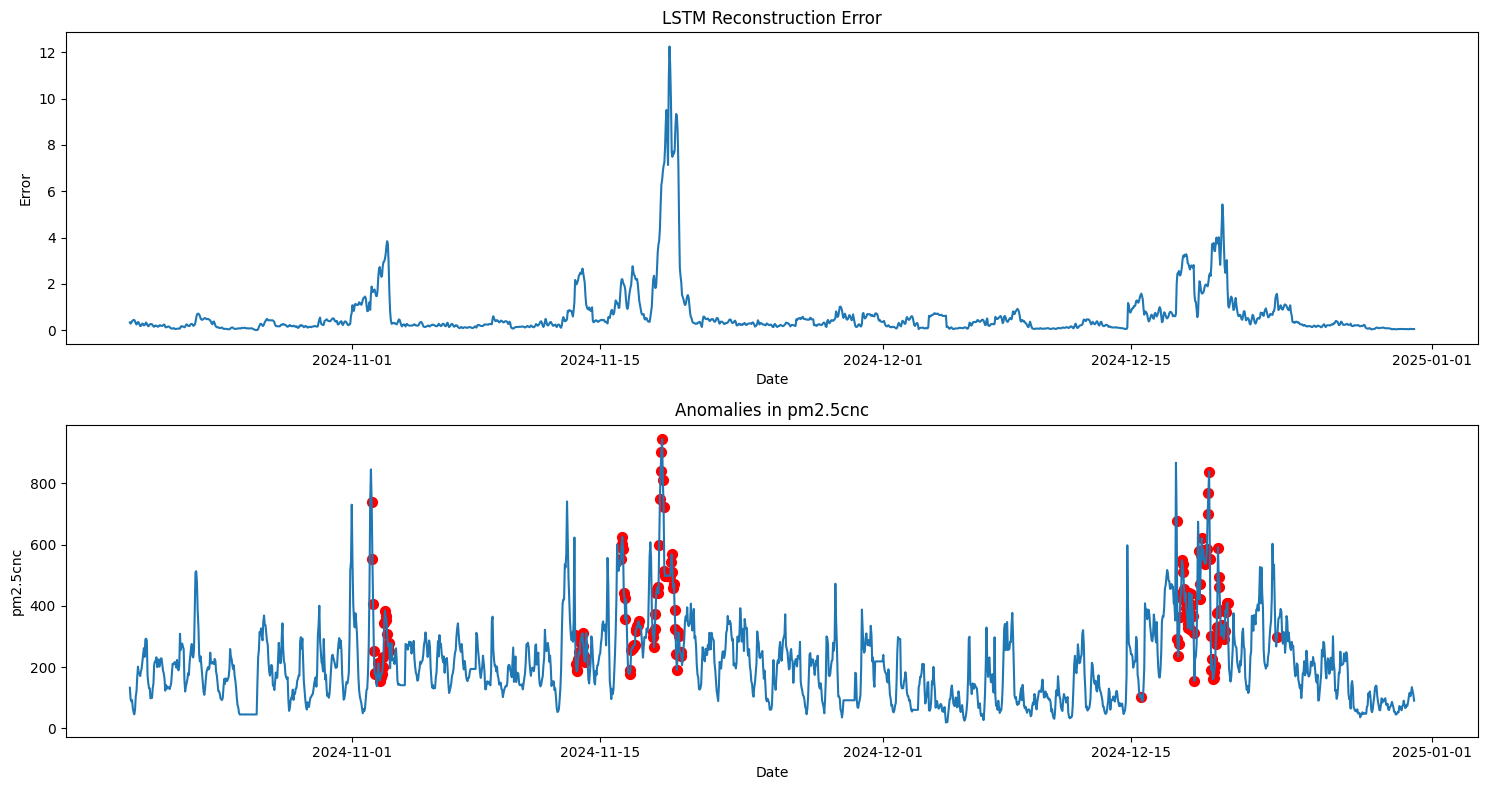

In [4]:
# Load and display the anomaly detection results
import pandas as pd

# Load the anomaly results
anomaly_results = pd.read_csv('lstm_reports/lstm_anomalies.csv', index_col=0, parse_dates=True)

# Display summary statistics
print(f"Total data points: {len(anomaly_results)}")
print(f"Total anomalies detected: {anomaly_results['anomaly'].sum()}")
print(f"Anomaly percentage: {anomaly_results['anomaly'].mean() * 100:.2f}%")

# Display the first few anomalies
print("\nFirst few detected anomalies:")
print(anomaly_results[anomaly_results['anomaly']].head())

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
# Plot reconstruction error
plt.subplot(2, 1, 1)
plt.plot(anomaly_results.index, anomaly_results['reconstruction_error'])
# Add horizontal line for threshold if available
if 'threshold' in anomaly_results.columns:
    plt.axhline(y=anomaly_results['threshold'].iloc[0], color='r', linestyle='--')
plt.title('LSTM Reconstruction Error')
plt.xlabel('Date')
plt.ylabel('Error')

# Plot a parameter with anomalies highlighted
param = 'pm2.5cnc'  # Adjust based on your data
if param in anomaly_results.columns:
    plt.subplot(2, 1, 2)
    plt.plot(anomaly_results.index, anomaly_results[param])
    anomalies = anomaly_results[anomaly_results['anomaly']]
    plt.scatter(anomalies.index, anomalies[param], color='red', s=50)
    plt.title(f'Anomalies in {param}')
    plt.xlabel('Date')
    plt.ylabel(param)

plt.tight_layout()
plt.show()